# Práctico 2 - Redes en escalera avanzadas

Este práctico es similar al práctico 1, pero agregará un paso extra que es el uso de redes en escalera avanzadas, ya sean Redes Convolucionales o Redes Recurrentes.

Se les dará, como base, el mismo conjunto de datos de la competencia "PetFinder" que se trabajó para el práctico 1, con el agregado de, en este caso, utilizar la descripción como un feature extra y todo el procesamiento que ello requiere.

Ahora bien, no es el único conjunto de datos que pueden trabajar. Si tienen un conjunto propio de datos que quieran utilizar y dicho conjunto se preste para el uso de alguna red en escalera avanzada (e.g. conjuntos que tengan imágenes o texto), son libres de hacerlo.

In [1]:
import nltk
import numpy as np
import os
import pandas as pd
#import tensorflow as tf

from IPython.display import SVG
from gensim import corpora
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint

nltk.download(["punkt", "stopwords"]);

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers, models

TensorFlow 2.x selected.


## Carga de los datos

In [16]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [19]:
import io

dataset = pd.read_csv(io.BytesIO(os.path.join(uploaded['train.csv'])))

target_col = 'AdoptionSpeed'
nlabels = dataset[target_col].unique().shape[0]

dataset.head(3)

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,AdoptionSpeed,PID
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,Nibble is a 3+ month old ball of cuteness. He ...,2,0
1,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,"Good guard dog, very alert, active, obedience ...",2,3
2,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,This handsome yet cute boy is up for adoption....,2,4


In [0]:
# NO EJECUTAR: cargamos con la celda de arriba
DATA_DIRECTORY = '../petfinder_dataset/'

In [0]:
# NO EJECUTAR: cargamos con la celda de arriba
dataset = pd.read_csv(os.path.join(DATA_DIRECTORY, 'train.csv'))

target_col = 'AdoptionSpeed'
nlabels = dataset[target_col].unique().shape[0]

dataset.head(3)

## Preproceso del texto para agregarlo como feature (manejo de secuencias)

A diferencia del práctico anterior, en este caso es necesario utilizar el texto como feature extra. Pueden luego agregarlo a una red recurrente o convolucional y concatenar su salida a los atributos "escalares" (como "raza" o "género").

A continuación les mostraremos los pasos a seguir para ello. La descripción detallada de para que sirve cada paso se encuentra disponible en el [notebook 3](./3_cnns.ipynb).

### Tokenización

In [0]:
SW = set(stopwords.words("english"))

def tokenize_description(description):
    return [w.lower() for w in word_tokenize(description, language="english") if w.lower() not in SW]

# Fill the null values with the empty string to avoid errors with NLTK tokenization
dataset["TokenizedDescription"] = dataset["Description"].fillna(value="").apply(tokenize_description)

#### Tamaño de las descripciones

Un punto importante a tener en cuenta es que las descripciones tienen tamaño variable, y esto no es compatible con los algoritmos de aprendizaje automático. Por lo que hay que llevar las secuencias a un tamaño uniforme.

Para definir dicho tamaño uniforme, es útil mirar qué tamaños mínimos, máximos y medios manejan las descripciones y a partir de esto establecer el tamaño máximo de la secuencia.

In [22]:
pprint(dataset["TokenizedDescription"].apply(len).describe())

count    10582.000000
mean        44.418541
std         48.464623
min          0.000000
25%         16.000000
50%         31.000000
75%         55.000000
max        803.000000
Name: TokenizedDescription, dtype: float64


Vemos que más del 75% de las secuencias tienen 55 palabras o menos. Esto es un buen punto de partida, así que podemos establecer el tamaño máximo de las secuencia en 55 palabras.

In [0]:
MAX_SEQUENCE_LEN = 55

## Vocabulario

In [0]:
vocabulary = corpora.Dictionary(dataset["TokenizedDescription"])
vocabulary.filter_extremes(no_below=1, no_above=1.0, keep_n=10000)

## Word Embeddings (GloVe)

In [25]:
from google.colab import files
glove = files.upload()

Saving glove.6B.100d.txt to glove.6B.100d.txt


In [0]:
import io

glove_file = io.BytesIO(os.path.join(glove['glove.6B.100d.txt']))


In [27]:
embeddings_index = {}

#with open("./dataset/glove.6B.100d.txt", "r") as fh:
with open("glove.6B.100d.txt", "r") as fh:
    for line in fh:
        values = line.split()
        word = values[0]
        if word in vocabulary.token2id:  # Only use the embeddings of words in our vocabulary
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

print("Found {} word vectors.".format(len(embeddings_index)))

Found 7897 word vectors.


## Creación de los datasets

Similar al práctico anterior, tendremos datos que serán "one-hot-encoded", otros serán "embeddings" y otros serán numéricos.

El caso particular del texto es que será tratado como una secuencia de embeddings, y dichos embeddings no serán entrenados en conjunto con la red, sino que serán tomados de un modelo "pre-entrenado". En este caso utilizamos GloVe, pero podríamos haber utilizado otro modelo (e.g. FastText).

In [0]:
# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in ['Gender', 'Color1', 'Color2'] #'Type', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health'
}
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1', 'Breed2'] #'State'
}
numeric_columns = ['Age', 'Quantity', 'Fee']

## Generador del conjunto de datos

Dada la naturaleza de los datos de texto, y que estos representan una secuencia de datos (que se da luego a una red recurrente o convolucional), en este caso no crearemos los datasets de antemano, sino que los generaremos a medida que el algoritmo de entrenamiento los pida. 

En particular, es porque las secuencias de texto pueden no tener el mismo tamaño (las oraciones tienen diferente cantidad de palabras), pero para que los modelos de redes las acepten, necesitamos rellenarlas (*padding*) de manera que todas tengan el mismo tamaño.

En este paso también vamos a truncar aquellas secuencias de descripciones con más de `MAX_SEQUENCE_LEN` palabras, de manera que al hacer uso de `padded_batch` no lance un error al encontrarse con secuencias de tamaño mayor.

In [134]:
def dataset_generator(ds, test_data=False):
    for _, row in ds.iterrows():
        instance = {}
        
        # One hot encoded features
        instance["direct_features"] = np.hstack([
            tf.keras.utils.to_categorical(row[one_hot_col] - 1, max_value)
            for one_hot_col, max_value in one_hot_columns.items()
        ])

        # Numeric features (should be normalized beforehand)
        # TODO: Add numeric features for row
        
        # Embedded features
        for embedded_col in embedded_columns:
            instance[embedded_col] = [row[embedded_col]]

        # DONE
        for n_col in numeric_columns:
            instance[n_col] = np.hstack(tf.keras.utils.normalize(ds[n_col].values)) 
        
        # Document to indices for text data, truncated at MAX_SEQUENCE_LEN words
        instance["description"] = vocabulary.doc2idx(
            row["TokenizedDescription"],
            unknown_word_index=len(vocabulary)
        )[:MAX_SEQUENCE_LEN]
        
        # One hot encoded target for categorical crossentropy
        if not test_data:
            target = tf.keras.utils.to_categorical(row[target_col], nlabels)
            yield instance, target
        else:
            yield instance

# Set output types of the generator (for numeric types check the type is valid)
instance_types = {
    "direct_features": tf.float32,
    "description": tf.int32
}

for embedded_col in embedded_columns:
    instance_types[embedded_col] = tf.int32

for n_col in numeric_columns:
    instance_types[n_col] = tf.int32
        
tf_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(dataset),
    output_types=(instance_types, tf.int32)
)

for data, target in tf_dataset.take(2):
    pprint(data)
    pprint(target)
    print()

{'Age': <tf.Tensor: shape=(10582,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>,
 'Breed1': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([299], dtype=int32)>,
 'Breed2': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'Fee': <tf.Tensor: shape=(10582,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>,
 'Quantity': <tf.Tensor: shape=(10582,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>,
 'description': <tf.Tensor: shape=(42,), dtype=int32, numpy=
array([23,  2, 20, 24,  4, 10,  1, 11, 26,  1, 27,  9,  6, 21,  3,  8, 15,
       22, 33,  7, 13, 30,  1, 29, 18, 17,  1, 12, 31, 14,  5,  6, 16,  1,
       19, 28, 25, 32, 23,  0,  5,  1], dtype=int32)>,
 'direct_features': <tf.Tensor: shape=(17,), dtype=float32, numpy=
array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)>}
<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 1, 0, 0], dtype=int32)>

{'Age': <tf.Tenso

## Datos de entrenamiento y validación

Ya generado el conjunto de datos base, tenemos que dividirlo en entrenamiento y validación. Además, como vamos a utilizar algunos datos que forman secuencias, los lotes (*batches*) de datos deben estar "rellenados" (*padded_batch*). 

Si bien rellenaremos "todos" los atributos, en la práctica el único que efectivamente se rellenará es el de *description* pues es el único con tamaños distintos.

In [135]:
TRAIN_SIZE = int(dataset.shape[0] * 0.8)
DEV_SIZE = dataset.shape[0] - TRAIN_SIZE
BATCH_SIZE = 128

shuffled_dataset = tf_dataset.shuffle(TRAIN_SIZE + DEV_SIZE, seed=42)

#Agrego
# Pad the datasets to the max value for all the "non sequence" features
padding_shapes = (
    {k: [-1] for k in ["direct_features"] + list(embedded_columns.keys()) + numeric_columns},
    [-1]
)

# Pad to MAX_SEQUENCE_LEN for sequence features
padding_shapes[0]["description"] = [MAX_SEQUENCE_LEN]

# Pad values are irrelevant for non padded data
padding_values = (
    {k: 0 for k in list(embedded_columns.keys())},
    0
)

# Padding value for direct features should be a float
padding_values[0]["direct_features"] = np.float32(0)

# Padding value for sequential features is the vocabulary length + 1
padding_values[0]["description"] = len(vocabulary) + 1

#Agrego
padding_values[0]["Age"] = np.int32(0)
padding_values[0]["Fee"] = np.int32(0)
padding_values[0]["Quantity"] = np.int32(0)

print(padding_shapes)
print(padding_values)
train_dataset = shuffled_dataset.skip(DEV_SIZE)\
    .padded_batch(BATCH_SIZE, padded_shapes=padding_shapes, padding_values=padding_values)

dev_dataset = shuffled_dataset.take(DEV_SIZE)\
    .padded_batch(BATCH_SIZE, padded_shapes=padding_shapes, padding_values=padding_values)

({'direct_features': [-1], 'Breed1': [-1], 'Breed2': [-1], 'Age': [-1], 'Quantity': [-1], 'Fee': [-1], 'description': [55]}, [-1])
({'Breed1': 0, 'Breed2': 0, 'direct_features': 0.0, 'description': 10001, 'Age': 0, 'Fee': 0, 'Quantity': 0}, 0)


## Construyendo el modelo

Al modelo anterior tenemos que agregarle la capa que maneje los embeddings de las palabras, e inicializarla de manera acorde, podemos guiarnos por lo visto en el [notebook 3](./3_cnns.ipynb) para hacer esto.

### Matriz de embeddings de palabras

In [0]:
EMBEDDINGS_DIM = 100  # Given by the model (in this case glove.6B.100d)

embedding_matrix = np.zeros((len(vocabulary) + 2, 100))

for widx, word in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[widx] = embedding_vector
    else:
        # Random normal initialization for words without embeddings
        embedding_matrix[widx] = np.random.normal(size=(100,))  

# Random normal initialization for unknown words
embedding_matrix[len(vocabulary)] = np.random.normal(size=(100,))

### Definiendo los inputs del modelo

Definamos los inputs del modelo, con el agregado de la capa de embeddings de palabras inicializada en `embedding_matrix`.

In [87]:
tf.keras.backend.clear_session()

# Add one input and one embedding for each embedded column
embedding_layers = []
numeric_layer = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = tf.keras.layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(
            tf.keras.layers.Embedding(
                input_dim=max_value, 
                output_dim=embedding_size
            )(input_layer), 
            axis=-2
        )
    )
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = tf.keras.layers.Input(
    shape=(sum(one_hot_columns.values()),), 
    name='direct_features'
)
inputs.append(direct_features_input)

# DONE: Add Numerics
for col in numeric_columns:
    input_num_layer = tf.keras.layers.Input(shape=(1,), name=col)
    inputs.append(input_num_layer)
    numeric_layer.append(input_num_layer)

# Word embedding layer
description_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LEN,), name="description")
inputs.append(description_input)

word_embeddings_layer = tf.keras.layers.Embedding(
    embedding_matrix.shape[0],
    EMBEDDINGS_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LEN,
    trainable=False,
    name="word_embedding"
)(description_input)

Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2


### Definiendo la red que trabajará con el texto

Antes de generar el *feature map* final entre los inputs y las clases, tenemos que generar el *feature map* de las secuencias de texto. 

Para ello pueden utilizar una red neuronal recurrente o convolucional.

Pueden pensar dicha red como un submodelo del modelo general que se encarga de generar los atributos que representan la descripción de la mascota (recordemos que las redes se utilizan para hacer aprendizaje de representaciones).

La red puede ser tan compleja como ustedes lo consideren pertinente.

In [88]:
## TODO: Create a NN (CNN or RNN) for the description input (replace the next)
#DESCRIPTION_FEATURES_LAYER_SIZE = 512

#description_features = tf.keras.layers.Flatten()(word_embeddings_layer)  # This is a simple concatenation
#description_features = tf.keras.layers.Dense(
#    units=DESCRIPTION_FEATURES_LAYER_SIZE, 
#    activation="relu", 
#    name="description_features")(description_features)

WORDS_SIZE = [2, 4, 8, 16]  # Fibonacci  :)
FILTER = 50

sequence_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LEN,), dtype='int64', name="input")

# The embedding layer is initialized with our embedding_matrix
embeddings_layer = tf.keras.layers.Embedding(
    embedding_matrix.shape[0],
    EMBEDDINGS_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LEN,
    trainable=False,
    name="word_embedding"
)
embedded_sequences = embeddings_layer(sequence_input)

# Convultional layer
conv_layers = []
for filter_width in WORDS_SIZE:
    layer = tf.keras.layers.Conv1D(
        FILTER,
        filter_width,
        activation="relu",
        name="conv_{}_words".format(filter_width)
    )(embedded_sequences)
    layer = tf.keras.layers.GlobalMaxPooling1D(name="max_pool_{}_words".format(filter_width))(layer)
    conv_layers.append(layer)

convolved_features = tf.keras.layers.Concatenate(name="convolved_features")(conv_layers)
output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(convolved_features)
model = tf.keras.models.Model(inputs=[sequence_input], outputs=[output], name="Red convolucional para texto")

model.compile(
    optimizer="nadam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

DESCRIPTION_FEATURES_LAYER_SIZE = 512

description_features = tf.keras.layers.Flatten()(word_embeddings_layer)  # This is a simple concatenation
description_features = tf.keras.layers.Dense(units=DESCRIPTION_FEATURES_LAYER_SIZE, 
                                             activation="relu", name="description_features")(description_features)



Model: "Red convolucional para texto"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55)]         0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 55, 100)      1000200     input[0][0]                      
__________________________________________________________________________________________________
conv_2_words (Conv1D)           (None, 54, 50)       10050       word_embedding[0][0]             
__________________________________________________________________________________________________
conv_4_words (Conv1D)           (None, 52, 50)       20050       word_embedding[0][0]             
_______________________________________________________________________

### Definiendo el *feature map* final de la red

Ahora que tenemos nuestra representación de las descripciones, pasamos a combinarlo con los demás features en la última parte de nuestra red.

In [0]:
HIDDEN_LAYER_SIZE = 512
DROPOUT = 0.25

feature_map = tf.keras.layers.Concatenate(name="feature_map")(
    embedding_layers + [description_features, direct_features_input] # + numeric_layer  #(se me rompe con las col numericas que tenia de anterior practico pero dejo las de word embedding)   
)

hidden_layer_lv1 = tf.keras.layers.Dense(HIDDEN_LAYER_SIZE, activation="relu")(feature_map)
drop1 = layers.Dropout(DROPOUT)(hidden_layer_lv1)
hidden_layer_lv2 = tf.keras.layers.Dense(HIDDEN_LAYER_SIZE / 2, activation="relu")(drop1)
drop2 = layers.Dropout(DROPOUT)(hidden_layer_lv2)
hidden_layer_lv3 = tf.keras.layers.Dense(HIDDEN_LAYER_SIZE / 4, activation="relu")(drop2)
output_layer = tf.keras.layers.Dense(nlabels, activation="softmax", name="output")(hidden_layer_lv3)  # Concatene layers output -> input
model = tf.keras.models.Model(inputs=inputs, outputs=[output_layer], name="amazing_model")

### Compilando y visualizando el modelo

In [138]:
model.compile(loss='categorical_crossentropy', 
              optimizer='nadam',
              metrics=['accuracy'])
model.summary()

Model: "amazing_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed2 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 55, 100)      1000200     description[0][0]                
______________________________________________________________________________________

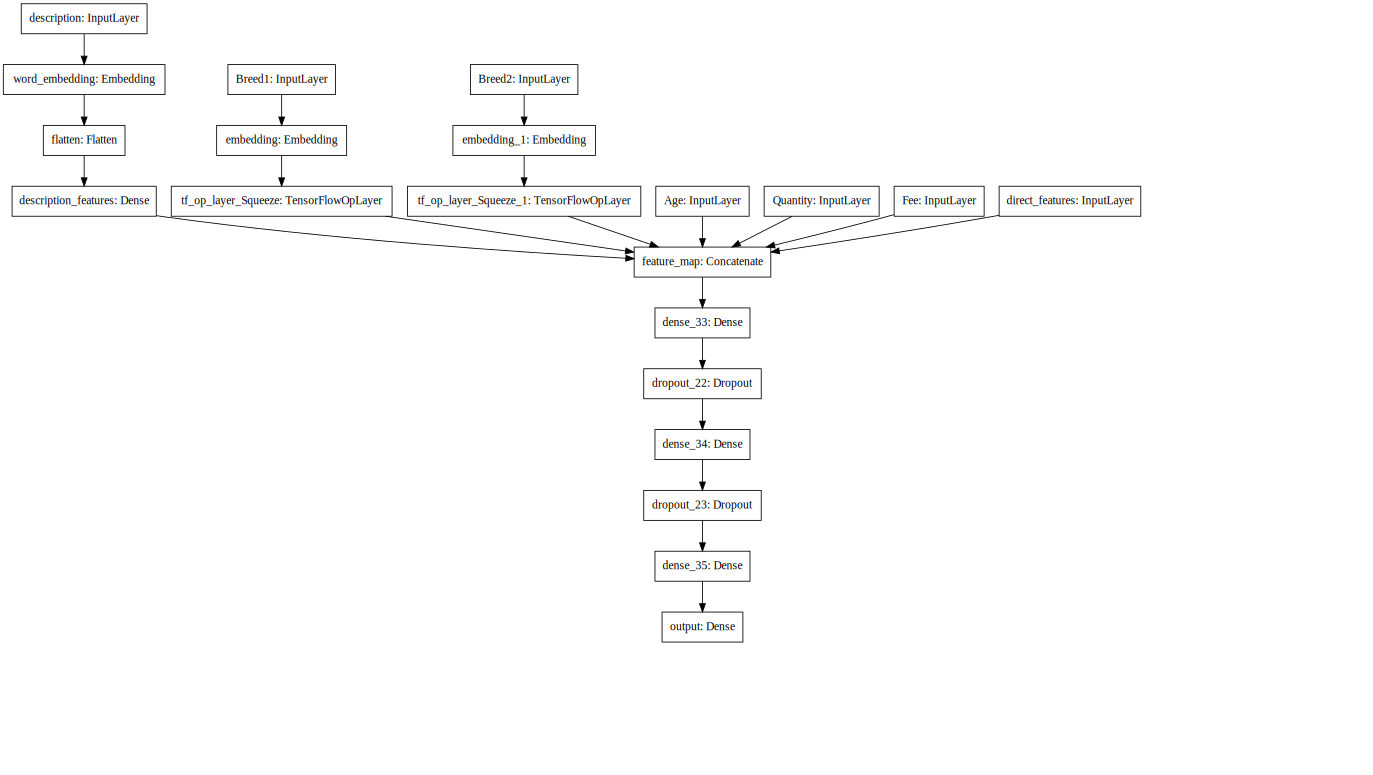

In [125]:
SVG(tf.keras.utils.model_to_dot(model, dpi=60).create(prog='dot', format='svg'))

## Entrenando el modelo

Para entrenar el modelo es igual al caso anterior, ya generados el conjunto de datos correspondiente. Lo entrenamos con ayuda de `mlflow`.

In [0]:
pip install mlflow

In [143]:
#RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

model.compile(loss='categorical_crossentropy', 
              optimizer='nadam',
              metrics=['accuracy'])
model.summary()

Model: "amazing_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed2 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 55, 100)      1000200     description[0][0]                
______________________________________________________________________________________

In [144]:
import mlflow

mlflow.set_experiment('very_base_approach') # awesome_advanced_approach
 
with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('description_features_layer_size', DESCRIPTION_FEATURES_LAYER_SIZE)
    mlflow.log_param('hidden_layer_size', HIDDEN_LAYER_SIZE)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    mlflow.log_param('numeric_columns', numeric_columns)  # Not using these yet
    
    # Train
    epochs = 10
    history = model.fit(train_dataset, epochs=epochs)
    
    # Evaluate
    loss, accuracy = model.evaluate(dev_dataset, verbose=0)
    print("\n*** Validation loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    #mlflow.log_metric('train_loss', history.history["loss"][-1])
    #mlflow.log_metric('train_accuracy', history.history["accuracy"][-1])
    mlflow.log_metric('validation_loss', loss)
    mlflow.log_metric('validation_accuracy', accuracy)

Epoch 1/10
67/67 [==============================] - 12s 185ms/step - loss: 0.5868 - accuracy: 0.7875
Epoch 2/10
67/67 [==============================] - 12s 176ms/step - loss: 0.1489 - accuracy: 0.9530
Epoch 3/10
67/67 [==============================] - 11s 167ms/step - loss: 0.1255 - accuracy: 0.9576
Epoch 4/10
67/67 [==============================] - 11s 168ms/step - loss: 0.1200 - accuracy: 0.9603
Epoch 5/10
67/67 [==============================] - 12s 173ms/step - loss: 0.0894 - accuracy: 0.9682
Epoch 6/10
67/67 [==============================] - 12s 175ms/step - loss: 0.1129 - accuracy: 0.9620
Epoch 7/10
67/67 [==============================] - 11s 170ms/step - loss: 0.0873 - accuracy: 0.9647
Epoch 8/10
67/67 [==============================] - 11s 171ms/step - loss: 0.0896 - accuracy: 0.9652
Epoch 9/10
67/67 [==============================] - 11s 170ms/step - loss: 0.1432 - accuracy: 0.9533
Epoch 10/10
67/67 [==============================] - 11s 169ms/step - loss: 0.0842 - accura

Comentarios:

Claramente el modelo realiza Overfiting ya que se llego a un valor de 0.40 con una red neuronal muy simple en el concurso anterior con el mismo dataset. En este caso tenemos valores que superan por lejos el baseline anterior.

Si utilizamos menos layers en el modelo o mayor dropout los resultados son mas reales, aunque podemos animarnos a decir, que el costo de agregar la descripcion no vale a las mejoras en los resultados obtenidos.

Al menos se consiguio aplicar una red convulsional para tratar el campo description. Por alguna razon que no determinamos, al ingresar los 3 campos numericos se rompe el modelo al momento de entrenarlo, ya que la matriz no coincide con las dimensiones esperadas, aunque se comparo con el ejercicio anterior no se identifica el lugar donde se produce el error en el codigo. Se agradece feedback al respecto.




